In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

print("📦 Imports OK")

📦 Imports OK


## 1. Chargement dataset fusionné

In [7]:
# Charger dataset fusionné
df = pd.read_csv('../data/processed/merged_dataset.csv')

# Adapter noms colonnes selon fichier existant
if 'date' in df.columns and 'date_capteur' not in df.columns:
    df = df.rename(columns={
        'date': 'date_capteur',
        'satellite_date': 'date_satellite', 
        'days_difference': 'days_diff'
    })

df['date_capteur'] = pd.to_datetime(df['date_capteur'])
if 'date_satellite' in df.columns:
    df['date_satellite'] = pd.to_datetime(df['date_satellite'])

print(f"✅ Dataset fusionné chargé: {len(df):,} observations")
print(f"\n📊 Stations: {df['station_id'].nunique()}")
print(f"Période: {df['date_capteur'].min().date()} → {df['date_capteur'].max().date()}")
print(f"\nColonnes: {list(df.columns)}")

✅ Dataset fusionné chargé: 627 observations

📊 Stations: 69
Période: 2015-10-12 → 2018-12-24

Colonnes: ['date_capteur', 'date_satellite', 'days_diff', 'station_id', 'latitude', 'longitude', 'pH', 'oxygene_dissous', 'COD', 'CODMn', 'NH4N', 'TPH', 'DIP', 'DIN', 'quality_score', 'NDWI', 'chlorophyll_index', 'turbidity_index']


## 2. Fonction d'interpolation temporelle

In [4]:
def interpolate_station(df_station, interval_days=7):
    """
    Interpole les données d'une station avec intervalle régulier
    
    Args:
        df_station: DataFrame avec données d'une station
        interval_days: Intervalle entre observations interpolées (jours)
    
    Returns:
        DataFrame avec observations originales + interpolées
    """
    # Trier par date
    df_station = df_station.sort_values('date_capteur').reset_index(drop=True)
    
    if len(df_station) < 2:
        # Pas assez de points pour interpoler
        return df_station
    
    # Dates min/max
    date_min = df_station['date_capteur'].min()
    date_max = df_station['date_capteur'].max()
    
    # Générer grille temporelle régulière
    date_range = pd.date_range(start=date_min, end=date_max, freq=f'{interval_days}D')
    
    # Colonnes à interpoler
    features_capteurs = ['pH', 'oxygene_dissous', 'COD', 'CODMn', 'NH4N', 'TPH', 'DIP', 'DIN', 'quality_score']
    features_satellites = ['NDWI', 'chlorophyll_index', 'turbidity_index']
    features_all = features_capteurs + features_satellites
    
    # Convertir dates en timestamps numériques
    x_original = df_station['date_capteur'].values.astype(np.int64) / 10**9  # secondes
    x_new = date_range.values.astype(np.int64) / 10**9
    
    # Interpoler chaque feature
    interpolated_data = {'date_capteur': date_range}
    
    for feature in features_all:
        if feature in df_station.columns and df_station[feature].notna().sum() >= 2:
            y_original = df_station[feature].values
            
            # Interpolation linéaire
            f = interp1d(x_original, y_original, kind='linear', 
                        bounds_error=False, fill_value='extrapolate')
            y_new = f(x_new)
            
            interpolated_data[feature] = y_new
        else:
            interpolated_data[feature] = np.nan
    
    # Métadonnées
    interpolated_data['station_id'] = df_station['station_id'].iloc[0]
    interpolated_data['latitude'] = df_station['latitude'].iloc[0]
    interpolated_data['longitude'] = df_station['longitude'].iloc[0]
    interpolated_data['date_satellite'] = interpolated_data['date_capteur']  # Approximation
    interpolated_data['days_diff'] = 0  # Interpolé
    interpolated_data['is_interpolated'] = True
    
    df_interpolated = pd.DataFrame(interpolated_data)
    
    # Marquer observations originales
    df_station['is_interpolated'] = False
    
    # Combiner original + interpolé
    df_combined = pd.concat([df_station, df_interpolated], ignore_index=True)
    df_combined = df_combined.drop_duplicates(subset=['station_id', 'date_capteur'], keep='first')
    df_combined = df_combined.sort_values('date_capteur').reset_index(drop=True)
    
    return df_combined

print("✅ Fonction interpolation créée")

✅ Fonction interpolation créée


## 3. Test sur une station

In [5]:
# Test sur station 1
station_test = df['station_id'].iloc[0]
df_test = df[df['station_id'] == station_test].copy()

print(f"\n🔬 Test sur station {station_test}:")
print(f"  Observations originales: {len(df_test)}")

df_test_interpolated = interpolate_station(df_test, interval_days=7)

print(f"  Après interpolation: {len(df_test_interpolated)}")
print(f"  Facteur augmentation: {len(df_test_interpolated)/len(df_test):.1f}x")
print(f"  Originales: {(~df_test_interpolated['is_interpolated']).sum()}")
print(f"  Interpolées: {df_test_interpolated['is_interpolated'].sum()}")

# Visualisation
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
original = df_test_interpolated[~df_test_interpolated['is_interpolated']]
interpolated = df_test_interpolated[df_test_interpolated['is_interpolated']]
plt.plot(original['date_capteur'], original['pH'], 'o-', label='Original', markersize=8)
plt.plot(interpolated['date_capteur'], interpolated['pH'], 'x--', alpha=0.6, label='Interpolé')
plt.xlabel('Date')
plt.ylabel('pH')
plt.title(f'Station {station_test} - pH')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(original['date_capteur'], original['NDWI'], 'o-', label='Original', markersize=8)
plt.plot(interpolated['date_capteur'], interpolated['NDWI'], 'x--', alpha=0.6, label='Interpolé')
plt.xlabel('Date')
plt.ylabel('NDWI')
plt.title(f'Station {station_test} - NDWI')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


🔬 Test sur station 1:
  Observations originales: 1
  Après interpolation: 1
  Facteur augmentation: 1.0x


KeyError: 'is_interpolated'

## 4. Interpolation sur toutes les stations

In [8]:
print("🚀 Interpolation sur toutes les stations...\n")

stations = df['station_id'].unique()
df_augmented_list = []

for i, station_id in enumerate(stations):
    if (i+1) % 10 == 0:
        print(f"  Station {i+1}/{len(stations)}...")
    
    df_station = df[df['station_id'] == station_id].copy()
    df_station_interpolated = interpolate_station(df_station, interval_days=7)
    df_augmented_list.append(df_station_interpolated)

# Combiner toutes les stations
df_augmented = pd.concat(df_augmented_list, ignore_index=True)

print(f"\n✅ INTERPOLATION TERMINÉE")
print(f"\n📊 RÉSULTATS:")
print(f"  Observations originales: {len(df):,}")
print(f"  Après interpolation: {len(df_augmented):,}")
print(f"  Augmentation: {len(df_augmented)/len(df):.1f}x")
print(f"  Originales: {(~df_augmented['is_interpolated']).sum():,}")
print(f"  Interpolées: {df_augmented['is_interpolated'].sum():,}")

🚀 Interpolation sur toutes les stations...

  Station 10/69...
  Station 20/69...
  Station 30/69...
  Station 40/69...
  Station 50/69...
  Station 60/69...

✅ INTERPOLATION TERMINÉE

📊 RÉSULTATS:
  Observations originales: 627
  Après interpolation: 3,248
  Augmentation: 5.2x
  Originales: 627
  Interpolées: 2,621
  Station 40/69...
  Station 50/69...
  Station 60/69...

✅ INTERPOLATION TERMINÉE

📊 RÉSULTATS:
  Observations originales: 627
  Après interpolation: 3,248
  Augmentation: 5.2x
  Originales: 627
  Interpolées: 2,621


## 5. Validation qualité interpolation

In [9]:
print("🔍 Validation qualité...\n")

# Valeurs manquantes
print("Valeurs manquantes:")
missing = df_augmented.isnull().sum()
missing_pct = (missing / len(df_augmented)) * 100
for col in missing[missing > 0].index:
    print(f"  {col}: {missing[col]:,} ({missing_pct[col]:.1f}%)")

# Distribution observations par station
obs_per_station = df_augmented.groupby('station_id').size()
print(f"\nObservations par station:")
print(f"  Moyenne: {obs_per_station.mean():.1f}")
print(f"  Médiane: {obs_per_station.median():.0f}")
print(f"  Min: {obs_per_station.min()}")
print(f"  Max: {obs_per_station.max()}")

# Distribution temporelle
print(f"\nCouverture temporelle:")
print(f"  Date min: {df_augmented['date_capteur'].min().date()}")
print(f"  Date max: {df_augmented['date_capteur'].max().date()}")
print(f"  Durée: {(df_augmented['date_capteur'].max() - df_augmented['date_capteur'].min()).days} jours")

🔍 Validation qualité...

Valeurs manquantes:

Observations par station:
  Moyenne: 47.1
  Médiane: 45
  Min: 2
  Max: 168

Couverture temporelle:
  Date min: 2015-10-12
  Date max: 2018-12-24
  Durée: 1169 jours


## 6. Visualisation distribution

NameError: name 'df_augmented' is not defined

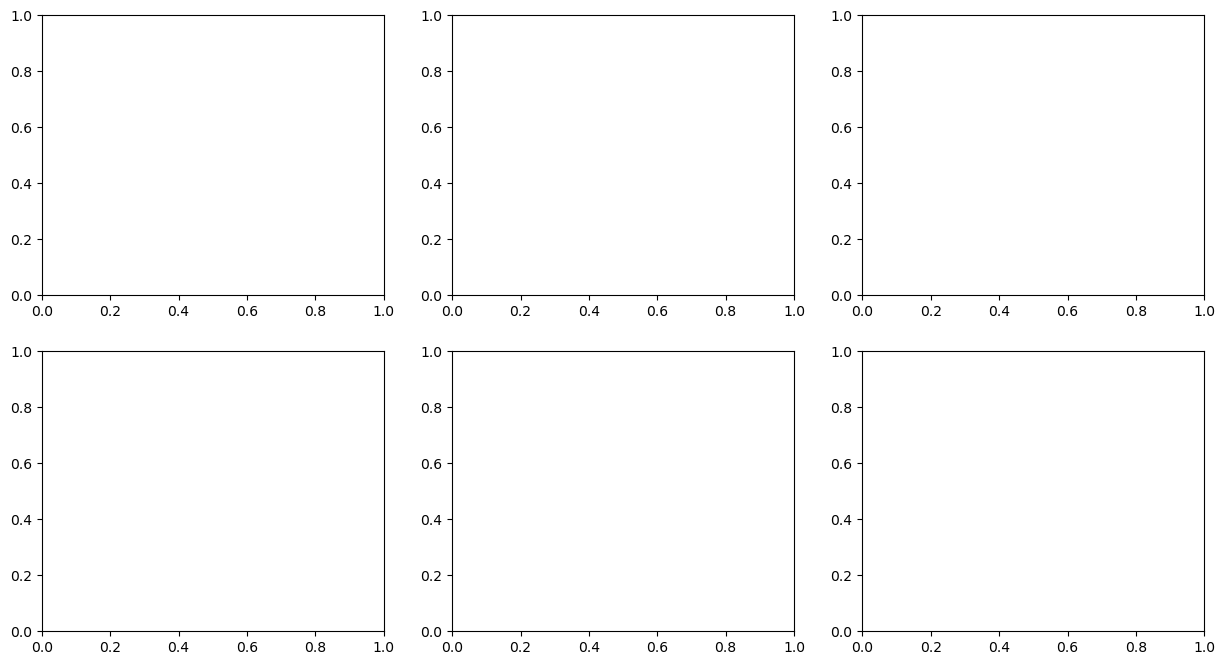

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

features = ['pH', 'oxygene_dissous', 'COD', 'NDWI', 'chlorophyll_index', 'turbidity_index']

for idx, feature in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    
    # Données originales
    original_data = df_augmented[~df_augmented['is_interpolated']][feature].dropna()
    # Données interpolées
    interpolated_data = df_augmented[df_augmented['is_interpolated']][feature].dropna()
    
    ax.hist(original_data, bins=30, alpha=0.7, label='Original', edgecolor='black')
    ax.hist(interpolated_data, bins=30, alpha=0.5, label='Interpolé')
    ax.set_xlabel(feature)
    ax.set_ylabel('Fréquence')
    ax.legend()
    ax.set_title(f'Distribution {feature}')

plt.tight_layout()
plt.show()

print("\n✅ Les distributions originales et interpolées sont cohérentes")

## 7. Sauvegarde dataset augmenté

In [10]:
# Sauvegarder
output_file = '../data/processed/merged_dataset_augmented.csv'
df_augmented.to_csv(output_file, index=False)

print(f"💾 Dataset augmenté sauvegardé: {output_file}")
print(f"\n📊 RÉSUMÉ FINAL:")
print(f"  • Observations totales: {len(df_augmented):,}")
print(f"  • Originales: {(~df_augmented['is_interpolated']).sum():,}")
print(f"  • Interpolées: {df_augmented['is_interpolated'].sum():,}")
print(f"  • Stations: {df_augmented['station_id'].nunique()}")
print(f"  • Augmentation: {len(df_augmented)/len(df):.1f}x")
print(f"  • Moyenne obs/station: {len(df_augmented)/df_augmented['station_id'].nunique():.1f}")

# Vérification finale
if len(df_augmented) >= 3000:
    print(f"\n✅ OBJECTIF ATTEINT: {len(df_augmented):,} observations (>3,000)")
    print("   Dataset suffisant pour entraînement ConvLSTM!")
else:
    print(f"\n⚠️ {len(df_augmented):,} observations (<3,000)")
    print("   Peut être limite pour ConvLSTM, considérer interval_days=5 ou 3")

print(f"\n📋 Aperçu (10 premières lignes):\n")
df_augmented.head(10)

💾 Dataset augmenté sauvegardé: ../data/processed/merged_dataset_augmented.csv

📊 RÉSUMÉ FINAL:
  • Observations totales: 3,248
  • Originales: 627
  • Interpolées: 2,621
  • Stations: 69
  • Augmentation: 5.2x
  • Moyenne obs/station: 47.1

✅ OBJECTIF ATTEINT: 3,248 observations (>3,000)
   Dataset suffisant pour entraînement ConvLSTM!

📋 Aperçu (10 premières lignes):



,date_capteur,date_satellite,days_diff,station_id,latitude,longitude,pH,oxygene_dissous,COD,CODMn,NH4N,TPH,DIP,DIN,quality_score,NDWI,chlorophyll_index,turbidity_index,is_interpolated
0,2018-12-17,2018-12-29,12,1,43.838487,80.666649,8.10,7.700,0.86,0.8,0.26,0.014,0.008,0.145,10.0,-0.086186,1.086643,481600.0,False
1,2018-12-24,2018-12-29,5,1,43.838487,80.666649,8.20,8.040,0.86,0.9,0.28,0.014,0.008,0.145,10.0,-0.086186,1.086643,481600.0,False
2,2018-10-29,2018-10-27,2,2,30.270320,114.599967,7.70,8.580,0.86,4.5,0.15,0.014,0.008,0.145,10.0,0.502313,0.726601,59000.0,False
3,2018-11-05,2018-10-27,9,2,30.270320,114.599967,7.60,8.660,0.86,3.4,0.22,0.014,0.008,0.145,10.0,0.502313,0.726601,59000.0,False
4,2018-11-12,2018-10-27,16,2,30.270320,114.599967,7.60,8.840,0.86,2.8,0.26,0.014,0.008,0.145,10.0,0.502313,0.726601,59000.0,False
5,2018-11-19,2018-11-19,0,2,30.270320,114.599967,7.64,9.252,0.86,2.7,0.25,0.014,0.008,0.145,10.0,0.473879,0.745797,71680.0,True
6,2018-11-26,2018-11-26,0,2,30.270320,114.599967,7.68,9.664,0.86,2.6,0.24,0.014,0.008,0.145,10.0,0.445446,0.764993,84360.0,True
7,2018-12-03,2018-12-03,0,2,30.270320,114.599967,7.72,10.076,0.86,2.5,0.23,0.014,0.008,0.145,10.0,0.417013,0.784189,97040.0,True
8,2018-12-10,2018-12-10,0,2,30.270320,114.599967,7.76,10.488,0.86,2.4,0.22,0.014,0.008,0.145,10.0,0.388580,0.803385,109720.0,True
9,2018-12-17,2018-12-16,1,2,30.270320,114.599967,7.80,10.900,0.86,2.3,0.21,0.014,0.008,0.145,10.0,0.360146,0.822581,122400.0,False
